In [7]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
def read_corpus(corpus_file, use_sentiment):
    documents = []
    labels = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            tokens = line.strip().split()

            documents.append(tokens[3:])

            if use_sentiment:
                # 2-class problem: positive vs negative
                labels.append( tokens[1] )
            else:
                # 6-class problem: books, camera, dvd, health, music, software
                labels.append( tokens[0] )

    return documents, labels
    
# a dummy function that just returns its input
def identity(x):
    return x

# reads the corpus and split to a training and test set
X, Y = read_corpus('trainset.txt', use_sentiment=False)
split_point = int(0.75*len(X))
Xtrain = X[:split_point]
Ytrain = Y[:split_point]
Xtest = X[split_point:]
Ytest = Y[split_point:]
X = np.array(X)
Y = np.array(Y)

# let's use the TF-IDF vectorizer
tfidf = True

# we use a dummy function as tokenizer and preprocessor,
# since the texts are already preprocessed and tokenized.
if tfidf:
    vec = TfidfVectorizer(preprocessor = identity,
                          tokenizer = identity)
else:
    vec = CountVectorizer(preprocessor = identity,
                          tokenizer = identity)

# combine the vectorizer with a classifier
classifier = Pipeline( [('vec', vec),
                        ('cls', tree.DecisionTreeClassifier())])

In [3]:
#cross validation with random sampling
kf = KFold(n_splits=5, shuffle=True)

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # train the classifier on X
    classifier.fit(X_train, y_train)

    # The classfier predicts the Ygeuss based on the Xtest after training
    y_guess = classifier.predict(X_test)
    print(accuracy_score(y_test, y_guess))  
    print(f1_score(y_test, y_guess, average='micro' ))

0.7483333333333333
0.7483333333333333
0.7733333333333333
0.7733333333333333
0.7583333333333333
0.7583333333333333
0.7758333333333334
0.7758333333333334
0.765
0.765


In [6]:
#plotting average accuracy over amount of k
kf = KFold(n_splits=5, shuffle=True)
K = range(1,100)


acc = []
f_score = []
for k in K: 

    # combine the vectorizer with a classifier
    classifier = Pipeline( [('vec', vec),
                            ('cls', KNeighborsClassifier(n_neighbors=k))])
    acc_splits = []
    f_score_splits = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        # train the classifier on X
        classifier.fit(X_train, y_train)

        # The classfier predicts the Ygeuss based on the Xtest after training
        y_guess = classifier.predict(X_test)
        acc_splits.append(accuracy_score(y_test, y_guess))
        f_score_splits.append(f1_score(y_test, y_guess, average='micro'))
    acc.append(np.average(acc_splits))
    f_score.append(np.average(f_score_splits))
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


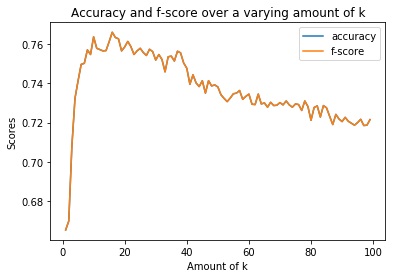

In [11]:
plt.plot(K, acc)
plt.plot(K, f_score)
plt.legend(['accuracy','f-score'])
plt.xlabel('Amount of k')
plt.ylabel('Scores')
plt.title('Accuracy and f-score over a varying amount of k')
plt.show()